Question9 - Rice_Grain_Counting

In [2]:
# Q9 — Rice grain counting on rice.png
# Pipeline: denoise → Otsu → morphology → connected components
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Make sure output directory exists
import os
os.makedirs(output_dir, exist_ok=True)

In [ ]:
input_image_path = "../data/a1images/rice.png"  # Path to the input rice image
output_dir = "../data/output_images"

output_denoised = f"{output_dir}/q9_denoised.png"
output_flattened = f"{output_dir}/q9_flattened.png"
output_mask = f"{output_dir}/q9_mask.png"
output_filled_mask = f"{output_dir}/q9_filled_mask.png"
output_segmented = f"{output_dir}/q9_segmented.png"
output_comparison = f"{output_dir}/q9_original_vs_segmented.png"

In [14]:
# ---------- (a) Load the image and apply light denoising ----------
g = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
if g is None:
    raise FileNotFoundError(input_image_path)

# Apply light Gaussian denoising
g_d = cv2.GaussianBlur(g, (3,3), 0.8)
cv2.imwrite(output_denoised, g_d)

True

In [15]:
# ---------- (b) Background flattening (key for rice) ----------
# Estimate background using a large morphological opening and subtract it
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31,31))  # Large disk-like kernel
bg = cv2.morphologyEx(g_d, cv2.MORPH_OPEN, k)
flat = cv2.subtract(g_d, bg)  # Remove illumination gradient
flat = cv2.normalize(flat, None, 0, 255, cv2.NORM_MINMAX)
cv2.imwrite(output_flattened, flat)

True

In [16]:
# ---------- (c) Otsu's thresholding to segment the rice grains ----------
_, th_raw = cv2.threshold(flat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Ensure grains are white and background is black
if np.mean(flat[th_raw > 0]) < np.mean(flat[th_raw == 0]):
    th_raw = cv2.bitwise_not(th_raw)

cv2.imwrite(output_mask, th_raw)

True

In [18]:
# ---------- (d) Apply morphological operations to clean small noise & fill holes ----------
# Small opening to remove small noise, followed by closing to fill small gaps
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
mask = cv2.morphologyEx(th_raw, cv2.MORPH_OPEN, se, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, se, iterations=2)

# Apply area-based opening to remove small objects by area (optional)
num, lab = cv2.connectedComponents(mask)
areas = np.bincount(lab.ravel())
keep = np.ones(num, np.uint8)
keep[0] = 0
minA, maxA = 30, 10_000  # Tweak these values if necessary
for i, a in enumerate(areas):
    if i == 0: continue
    if a < minA or a > maxA: keep[i] = 0
mask = (keep[lab] * 255).astype(np.uint8)

# Fill holes inside rice grains
def fill_holes(bin255):
    inv = cv2.bitwise_not(bin255)
    h, w = inv.shape
    ffmask = np.zeros((h + 2, w + 2), np.uint8)
    flood = inv.copy()
    cv2.floodFill(flood, ffmask, (0, 0), 255)
    holes = cv2.bitwise_not(flood)
    return cv2.bitwise_or(bin255, holes)

mask_filled = fill_holes(mask)
cv2.imwrite(output_filled_mask, mask_filled)

True

In [19]:
# ---------- (e) Count rice grains using connected components ----------
n_final, lab_final = cv2.connectedComponents((mask_filled > 0).astype(np.uint8))
count = n_final - 1  # Subtract 1 to exclude the background

In [20]:
# ---------- (f) Segment the rice grains and visualize the results ----------
# Optional: Watershed algorithm to separate touching grains (if necessary)
bin8 = (mask_filled > 0).astype(np.uint8)
dist = cv2.distanceTransform(bin8, cv2.DIST_L2, 5)
markers = (dist > 0.45 * dist.max()).astype(np.uint8)  # Peak seeds
_, markers = cv2.connectedComponents(markers)
markers = markers + 1
markers[bin8 == 0] = 0

rgb_for_ws = cv2.cvtColor(g, cv2.COLOR_GRAY2RGB)
ws = cv2.watershed(rgb_for_ws.copy(), markers.astype(np.int32))
seg = (ws > 1).astype(np.uint8) * 255
cv2.imwrite(output_segmented, seg)

True

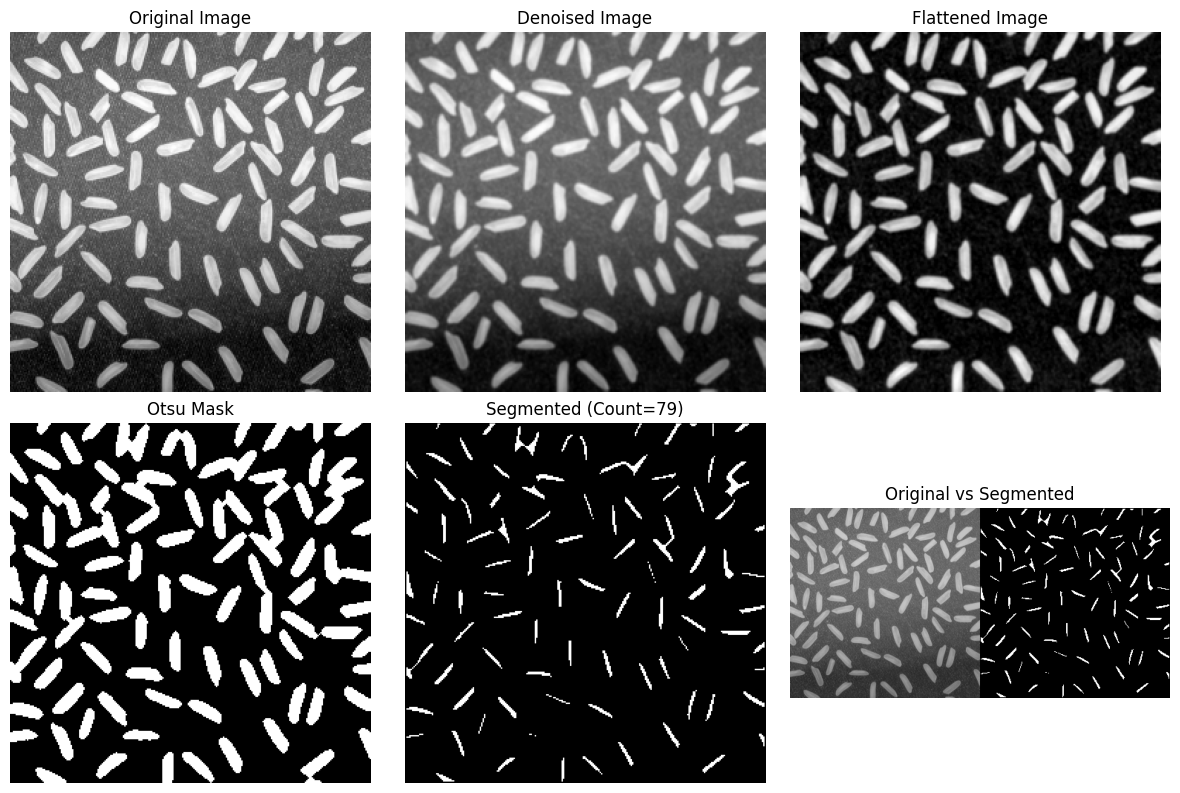

In [22]:
# ---------- (g) Display Results ----------
# Convert 2D segmentation mask to 3D for side-by-side comparison
seg_rgb = cv2.cvtColor(seg, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(12,8))
plt.subplot(2,3,1); plt.title("Original Image");          plt.imshow(g, cmap="gray"); plt.axis("off")
plt.subplot(2,3,2); plt.title("Denoised Image");          plt.imshow(g_d, cmap="gray"); plt.axis("off")
plt.subplot(2,3,3); plt.title("Flattened Image");         plt.imshow(flat, cmap="gray"); plt.axis("off")
plt.subplot(2,3,4); plt.title("Otsu Mask");               plt.imshow(mask_filled, cmap="gray"); plt.axis("off")
plt.subplot(2,3,5); plt.title(f"Segmented (Count={count})"); plt.imshow(seg, cmap="gray"); plt.axis("off")
plt.subplot(2,3,6); plt.title("Original vs Segmented");   plt.imshow(np.hstack([rgb_for_ws, seg_rgb])); plt.axis("off")
plt.tight_layout()
plt.show()
